1) Load + quick inspect

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("myntra_dataset_ByScraping.csv")
df

,brand_name,pants_description,price,MRP,discount_percent,ratings,number_of_ratings
0,WROGN,Men Loose Fit Cotton Jeans,1374.0,2499.0,0.45,4.2,57.0
1,Flying Machine,Men Slim Fit Jeans,1829.0,2999.0,0.39,4.6,5.0
2,Roadster,Men Pure Cotton Jeans,974.0,2499.0,0.61,3.6,1100.0
3,Bene Kleed,Relaxed Fit Denim Jeans,873.0,2299.0,0.62,4.0,4800.0
4,Levis,Men 511 Slim Fit Jeans,1478.0,2899.0,0.49,4.3,264.0
...,...,...,...,...,...,...,...
52115,Pepe Jeans,Men Slim Fit Jeans,759.0,1899.0,0.60,4.0,63.0
52116,HERE&NOW,Men Slim Fit Jeans,759.0,1899.0,0.60,4.0,63.0
52117,Pepe Jeans,Men Slim Fit Jeans,759.0,1899.0,0.60,4.0,63.0
52118,Celio,Men Straight Fit Jeans,759.0,1899.0,0.60,4.0,63.0


2) Cleaning / parsing prices & discounts

In [3]:
import re
def parse_price(x):
    if pd.isna(x): return None
    s = str(x)
    # remove currency symbols and commas
    s = re.sub(r'[^\d.]', '', s)
    try:
        return float(s)
    except:
        return None

# example column names; adjust if different
for col in ['price', 'mrp', 'discount']:
    if col in df.columns:
        df[col + '_num'] = df[col].apply(parse_price)

# If discount isn't present or inconsistent, compute it
if 'price_num' in df.columns and 'mrp_num' in df.columns:
    df['discount_pct'] = ((df['mrp_num'] - df['price_num']) / df['mrp_num']).clip(0,1)*100


In [4]:
import re
import numpy as np

# helper to clean ₹1,299 → 1299
def parse_price(x):
    if pd.isna(x): return None
    s = str(x)
    s = re.sub(r'[^\d.]', '', s)
    try:
        return float(s)
    except:
        return None

# clean price + MRP
df['price_num'] = df['price'].apply(parse_price)
df['mrp_num'] = df['MRP'].apply(parse_price)

# clean discount (already % but might have strings like '40% OFF')
def parse_discount(x):
    if pd.isna(x): return None
    s = re.sub(r'[^\d.]', '', str(x))
    try:
        return float(s)
    except:
        return None

df['discount_pct'] = df['discount_percent'].apply(parse_discount)

# reviews (number_of_ratings)
def parse_reviews(x):
    if pd.isna(x): return 0
    s = str(x).lower().strip()
    if 'k' in s:
        return float(s.replace('k','')) * 1000
    if 'm' in s:
        return float(s.replace('m','')) * 1_000_000
    try:
        return float(re.sub(r'[^\d.]','',s))
    except:
        return 0

df['reviews_num'] = df['number_of_ratings'].apply(parse_reviews)

# log transformation
df['log_reviews'] = np.log1p(df['reviews_num'])

# ratio (safe division)
df['price_to_mrp_ratio'] = np.where(df['mrp_num']>0, df['price_num']/df['mrp_num'], None)

# popularity proxy (ratings * log_reviews)
df['popularity_score'] = df['ratings'] * df['log_reviews']


EDA

1. Price & Discount Distribution

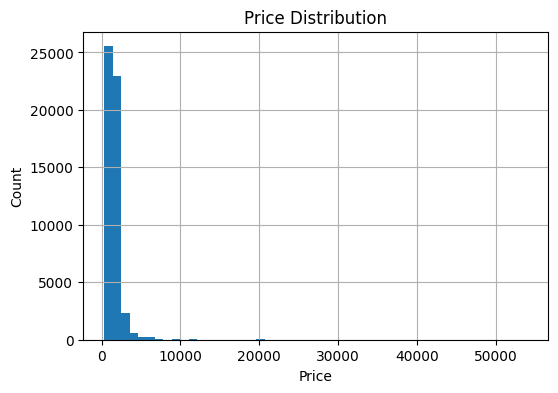

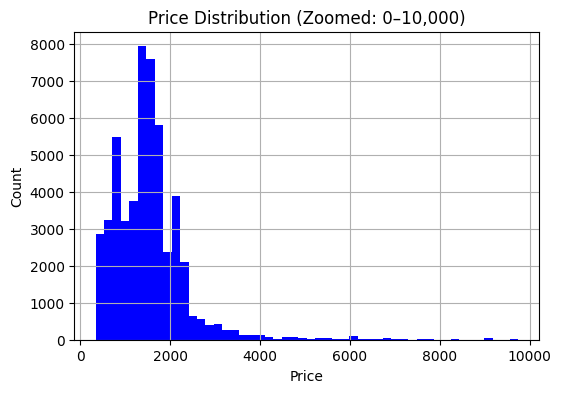

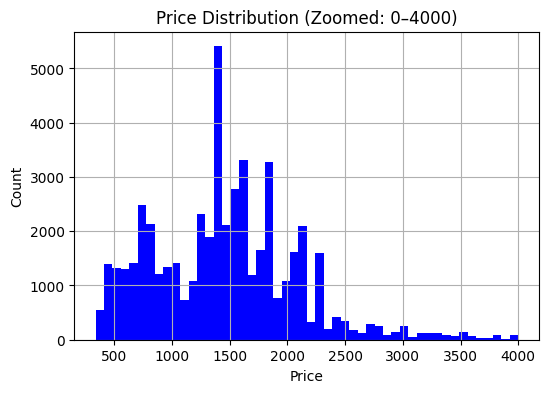

In [5]:
plt.figure(figsize=(6,4))
df['price_num'].hist(bins=50)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
df[df['price_num'] <= 10000]['price_num'].hist(bins=50, color='blue')
plt.title("Price Distribution (Zoomed: 0–10,000)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
df[df['price_num'] <= 4000]['price_num'].hist(bins=50, color='blue')
plt.title("Price Distribution (Zoomed: 0–4000)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

Brand-Level Analysis

2. Ratings & Reviews Analysis

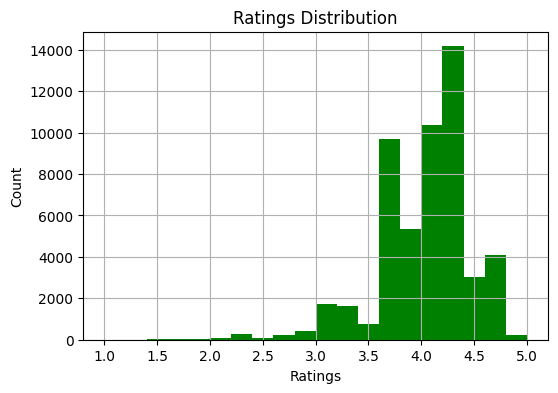

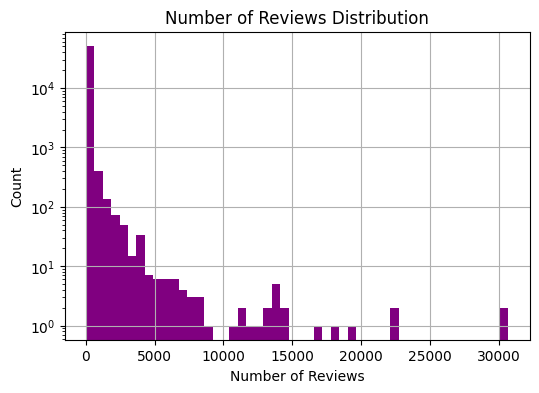

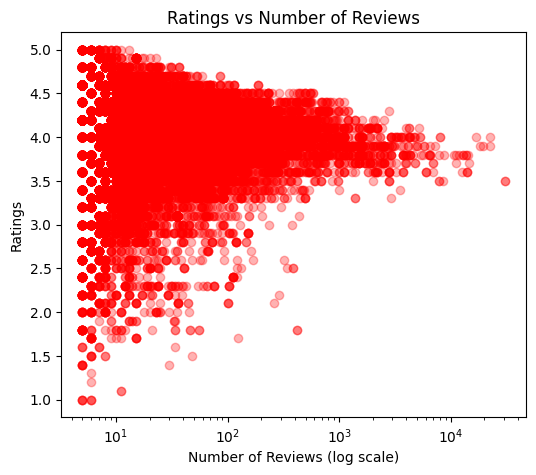

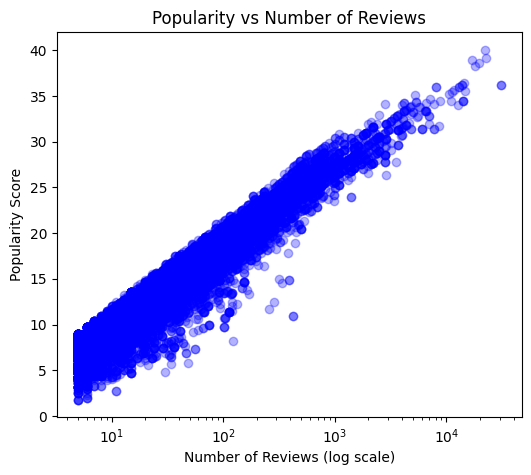

C:\Users\baran\AppData\Local\Temp\ipykernel_26424\2929017417.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_by_bucket = df.groupby('review_bucket')['ratings'].mean()


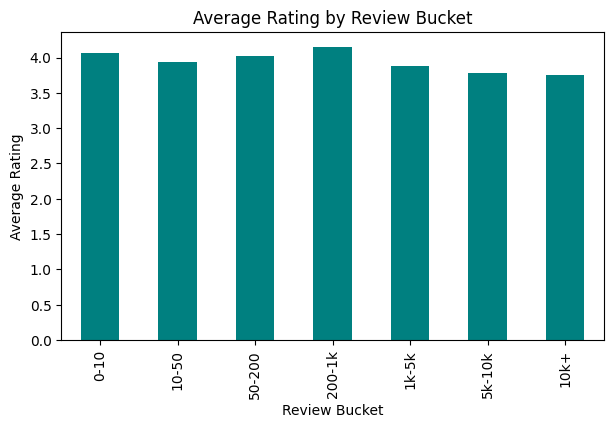

In [7]:
plt.figure(figsize=(6,4))
df['ratings'].hist(bins=20, color='green')
plt.title("Ratings Distribution")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
df['reviews_num'].hist(bins=50, color='purple')
plt.title("Number of Reviews Distribution")
plt.xlabel("Number of Reviews")
plt.ylabel("Count")
plt.yscale("log")  # log scale to handle skew
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df['reviews_num'], df['ratings'], alpha=0.3, color='red')
plt.xscale("log")
plt.title("Ratings vs Number of Reviews")
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Ratings")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df['reviews_num'], df['popularity_score'], alpha=0.3, color='blue')
plt.xscale("log")
plt.title("Popularity vs Number of Reviews")
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Popularity Score")
plt.show()

df['review_bucket'] = pd.cut(df['reviews_num'], 
                             bins=[0,10,50,200,1000,5000,10000,50000],
                             labels=["0-10","10-50","50-200","200-1k","1k-5k","5k-10k","10k+"])

rating_by_bucket = df.groupby('review_bucket')['ratings'].mean()

plt.figure(figsize=(7,4))
rating_by_bucket.plot(kind='bar', color='teal')
plt.title("Average Rating by Review Bucket")
plt.xlabel("Review Bucket")
plt.ylabel("Average Rating")
plt.show()


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Features and target
features = ['price_num','discount_pct','ratings','reviews_num','price_to_mrp_ratio','log_reviews']
X = df[features].fillna(0)
y = df['popularity_score'].fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\baran\AppData\Local\Temp\ipykernel_26424\1220582254.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = df[features].fillna(0)


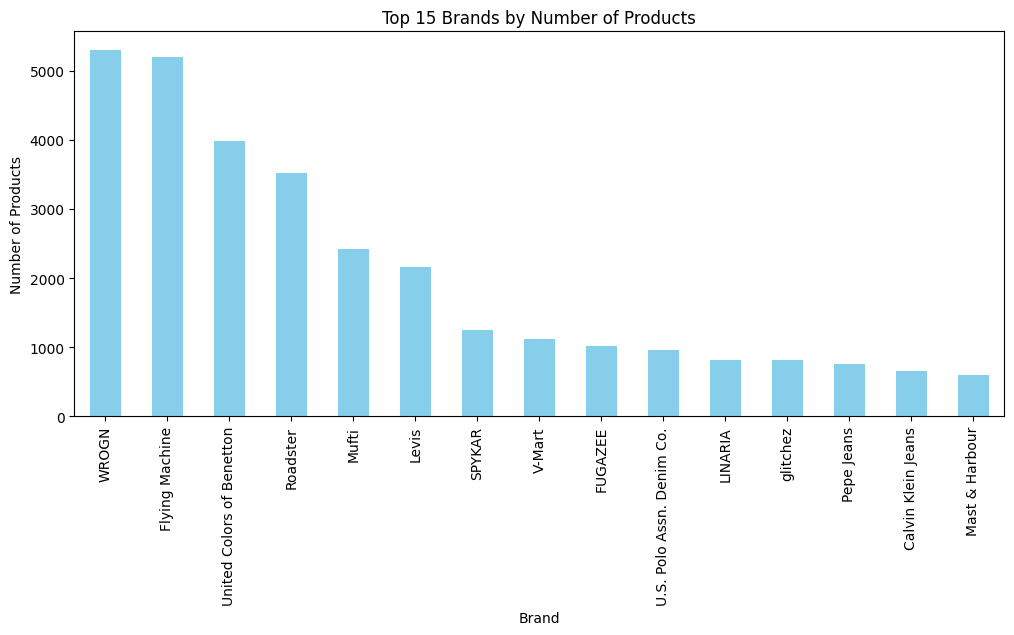

C:\Users\baran\AppData\Local\Temp\ipykernel_26424\2385407241.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_brands_popularity, x='brand_name', y='avg_popularity', palette="viridis")


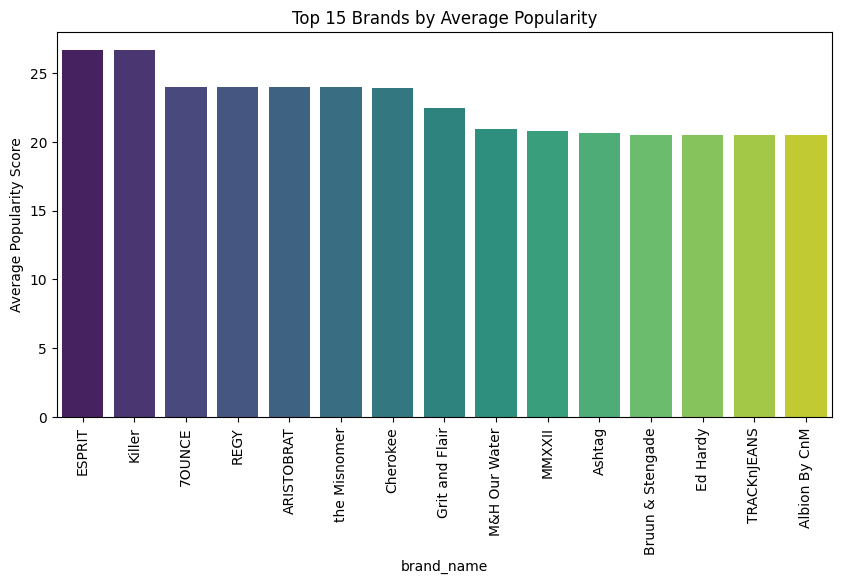

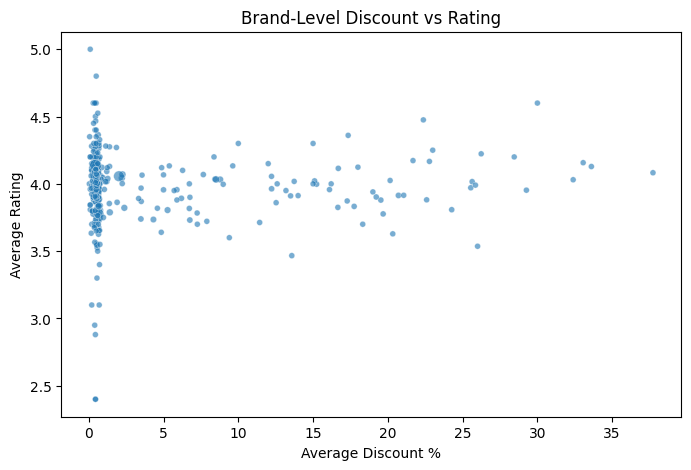

,brand_name,avg_rating,rating_variance,n_products
1,7OUNCE,4.3,0.0,3
117,FIBONACCI,3.7,0.0,3
110,ESPRIT,3.9,0.0,2
230,MR BUTTON,3.7,0.0,4
20,Albion By CnM,4.2,0.0,2
416,the Misnomer,4.3,0.0,3
193,Killer,3.9,0.0,2
347,The Dance Bible,4.2,0.0,2
14,ARISTOBRAT,4.3,0.0,2
342,TRACKnJEANS,4.2,0.0,2


In [13]:
top_brands_count = df['brand_name'].value_counts().head(15)

plt.figure(figsize=(12,5))
top_brands_count.plot(kind='bar', color='skyblue')
plt.title("Top 15 Brands by Number of Products")
plt.xlabel("Brand")
plt.ylabel("Number of Products")
plt.xticks(rotation=90)
plt.show()

brand_summary = df.groupby('brand_name').agg(
    n_products=('pants_description','count'),
    avg_rating=('ratings','mean'),
    avg_discount=('discount_pct','mean'),
    avg_price=('price_num','mean'),
    avg_popularity=('popularity_score','mean'),
    rating_variance=('ratings','std')
).reset_index()

brand_summary.sort_values('n_products', ascending=False).head(10)

top_brands_popularity = brand_summary.sort_values('avg_popularity', ascending=False).head(15)

plt.figure(figsize=(10,5))
sns.barplot(data=top_brands_popularity, x='brand_name', y='avg_popularity', palette="viridis")
plt.title("Top 15 Brands by Average Popularity")
plt.xticks(rotation=90)
plt.ylabel("Average Popularity Score")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=brand_summary, x='avg_discount', y='avg_rating', size='n_products', alpha=0.6, legend=False)
plt.title("Brand-Level Discount vs Rating")
plt.xlabel("Average Discount %")
plt.ylabel("Average Rating")
plt.show()

consistent_brands = brand_summary.sort_values('rating_variance').head(10)
consistent_brands[['brand_name','avg_rating','rating_variance','n_products']]


In [14]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Metrics
import numpy as np

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 0.046883533217679824
R² Score: 0.999909339134758


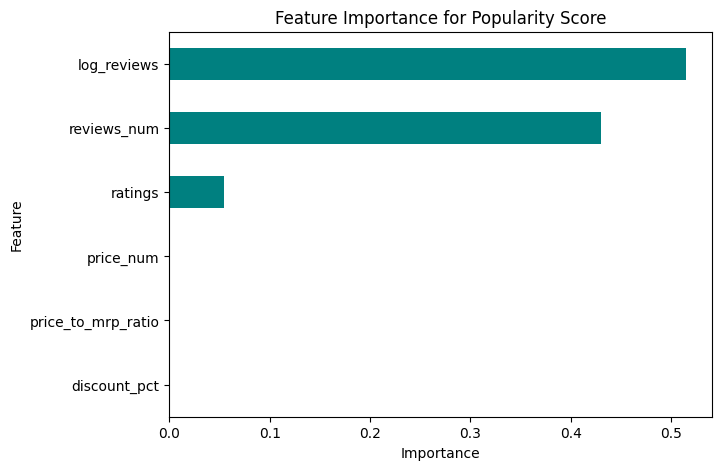

In [15]:
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(7,5))
importances.plot(kind='barh', color='teal')
plt.title("Feature Importance for Popularity Score")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
